In [5]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

# Optional plotting function
if True:
    import re
    import os
    import matplotlib
    import matplotlib.font_manager as font_manager

    font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
    assert os.path.exists(font_path)
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    matplotlib.rc('font', family='sans-serif')
    matplotlib.rcParams.update({
        'font.size': 12,
        'font.sans-serif': prop.get_name(),
        'axes.titlesize': 12
    })


In [6]:
alldata = pd.read_pickle('./Final/ml_input.pkl')

clin = ['clingen','eva','gene2phenotype','genomics_england','orphanet','uniprot_literature', 'uniprot_variants','omim']
ot = ['clin_ot','hgmd','gwas_credible_sets','expression_atlas','impc','europepmc']
ot_all = ['clin_ot','hgmd','omim','gene_burden','gwas_credible_sets','cancer_gene_census','eva_somatic','reactome','expression_atlas','impc','europepmc']
mantis = ['mantis']
cc = ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']

min1 = alldata.loc[alldata[ot+mantis+cc].max(axis=1) > 0]
nps = alldata.loc[(alldata[['clin_ot','hgmd','omim']].max(axis=1) == 0)]


## SHAP

In [7]:
shap = pd.read_pickle('./GPS/Main/SHAP/holdout_shap_ot_mantis_cc.pkl')
shap['phecode'] = shap['id'].str.split(':').str[0]
shapdata = shap[['id']].merge(alldata[shap.columns], on='id')

shap = shap.set_axis(['id','Clinical genetics','HGMD','L2G','Gene expression',
                      'Mouse models','Text mining','Mantis-ML','Common variants','Rare variants',
                      'Rare variants (gene-level)','Ultrarare variants (gene-level)','phecode'],axis=1)

shapdata = shapdata.set_axis(['id','Clinical genetics','HGMD','L2G','Gene expression',
                      'Mouse models','Text mining','Mantis-ML','Common variants','Rare variants',
                      'Rare variants (gene-level)','Ultrarare variants (gene-level)','phecode'],axis=1)


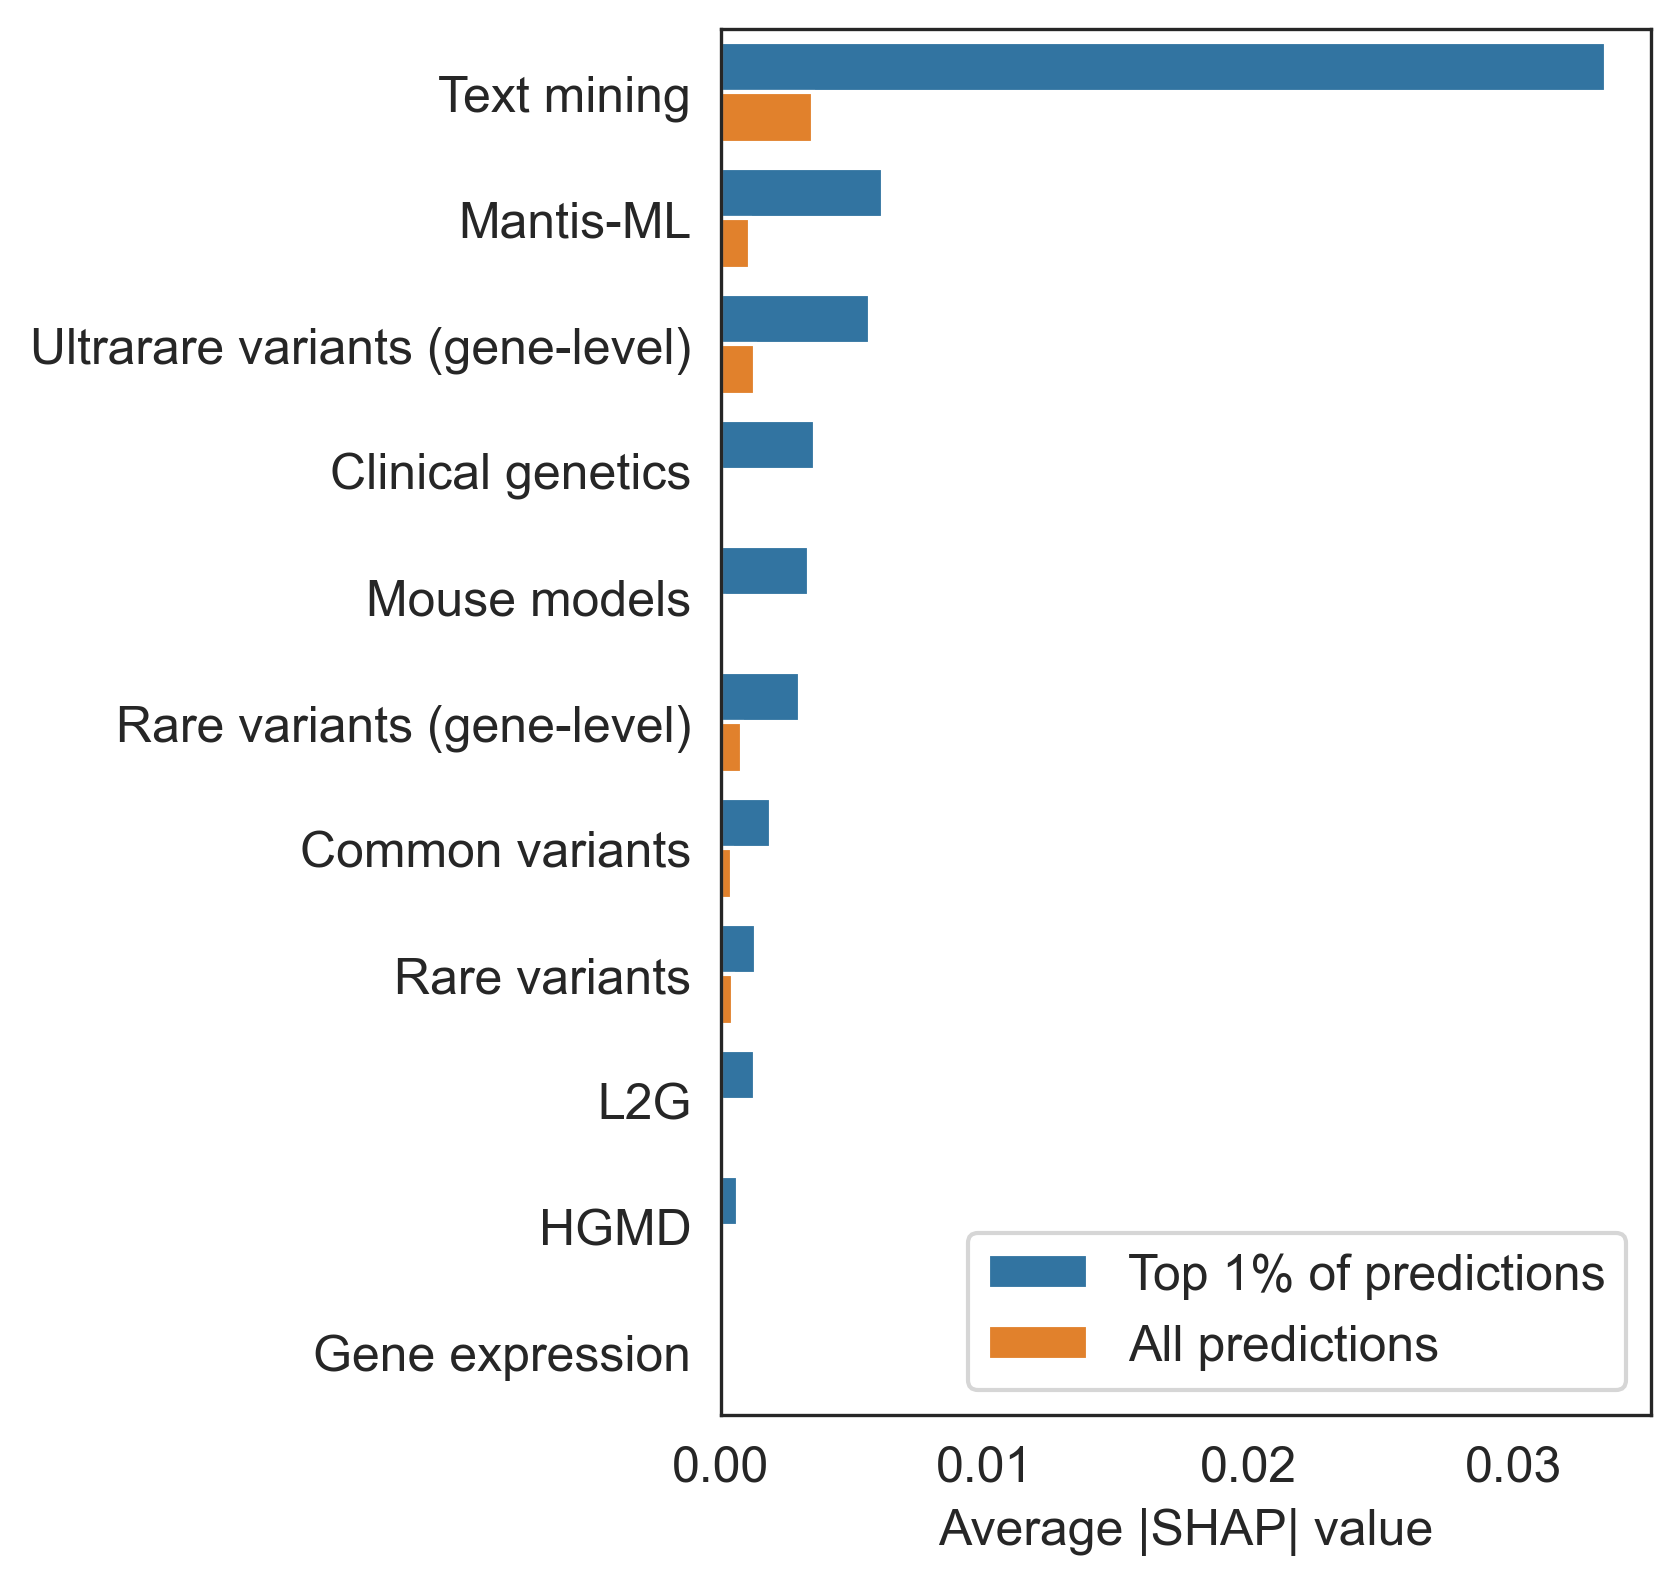

In [8]:
pred = pd.read_pickle('./GPS/Main/Predictions/holdout_predictions_ot_mantis_cc.pkl').sort_values('prediction', ascending=False)
pred_01 = pred[:(round(len(pred)*0.01))]

#####

avgdf = pd.DataFrame()

avg = shap.loc[shap['id'].isin(pred_01['id'])]
avg = avg.drop(['id','phecode'],axis=1).abs().mean().reset_index()
avg = avg.sort_values(0, ascending=False)
avg = avg.loc[avg['index'] != 'Genetic associations']
avg = avg.copy().set_axis(['Feature','SHAP'],axis=1)
avg['Category'] = 'Top 1% of predictions'
avgdf = pd.concat([avgdf, avg])

avg = shap.drop(['id','phecode'],axis=1).abs().mean().reset_index()
avg = avg.sort_values(0, ascending=False)
avg = avg.loc[avg['index'] != 'Genetic associations']
avg = avg.set_axis(['Feature','SHAP'],axis=1)
avg['Category'] = 'All predictions'
avgdf = pd.concat([avgdf, avg])

#####

plt.figure(figsize=(4, 6), dpi=300)
sns.set_style('white')

sns.barplot(avgdf, x='SHAP', y='Feature', hue='Category')
plt.xlabel('Average |SHAP| value')
plt.ylabel('')
plt.legend(title='', loc='lower right')


Text(0.5, 1.0, 'HGMD')

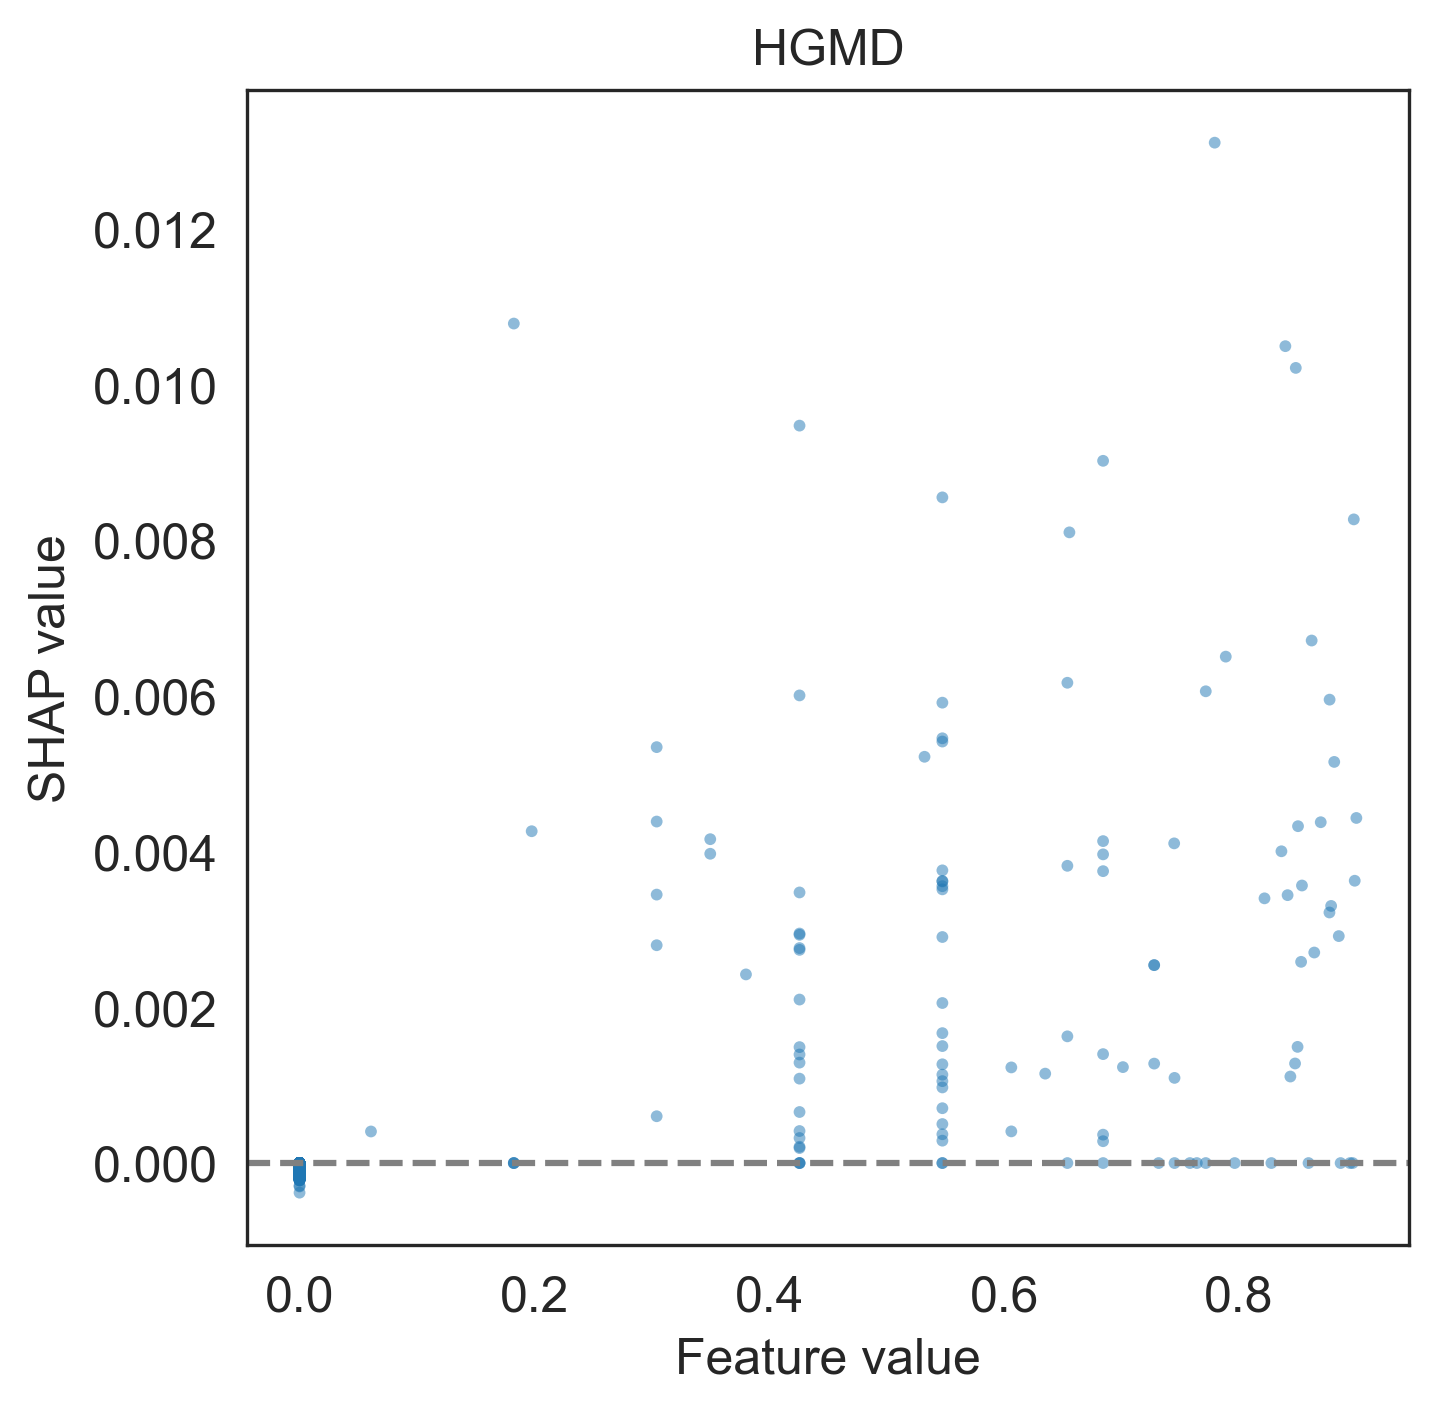

In [12]:
feature = ['Gene expression', 'HGMD', 'L2G', 'Mouse models', 'Clinical genetics', 'Text mining',
           'Mantis-ML'][1]
temp = shap[['id',feature]].set_axis(['id','SHAP value'],axis=1)\
        .merge(shapdata[['id',feature]].set_axis(['id','Feature value'],axis=1), on='id')
temp = temp.loc[temp['Feature value'].notna()]

plt.figure(figsize=(5, 5), dpi=300)
sns.set_style('white')

sns.scatterplot(temp.sample(frac=0.1), x='Feature value', y='SHAP value', alpha=0.5,
                s=8, edgecolor='none')

plt.axhline(y=0, color='gray', linestyle='--')
plt.title(feature)


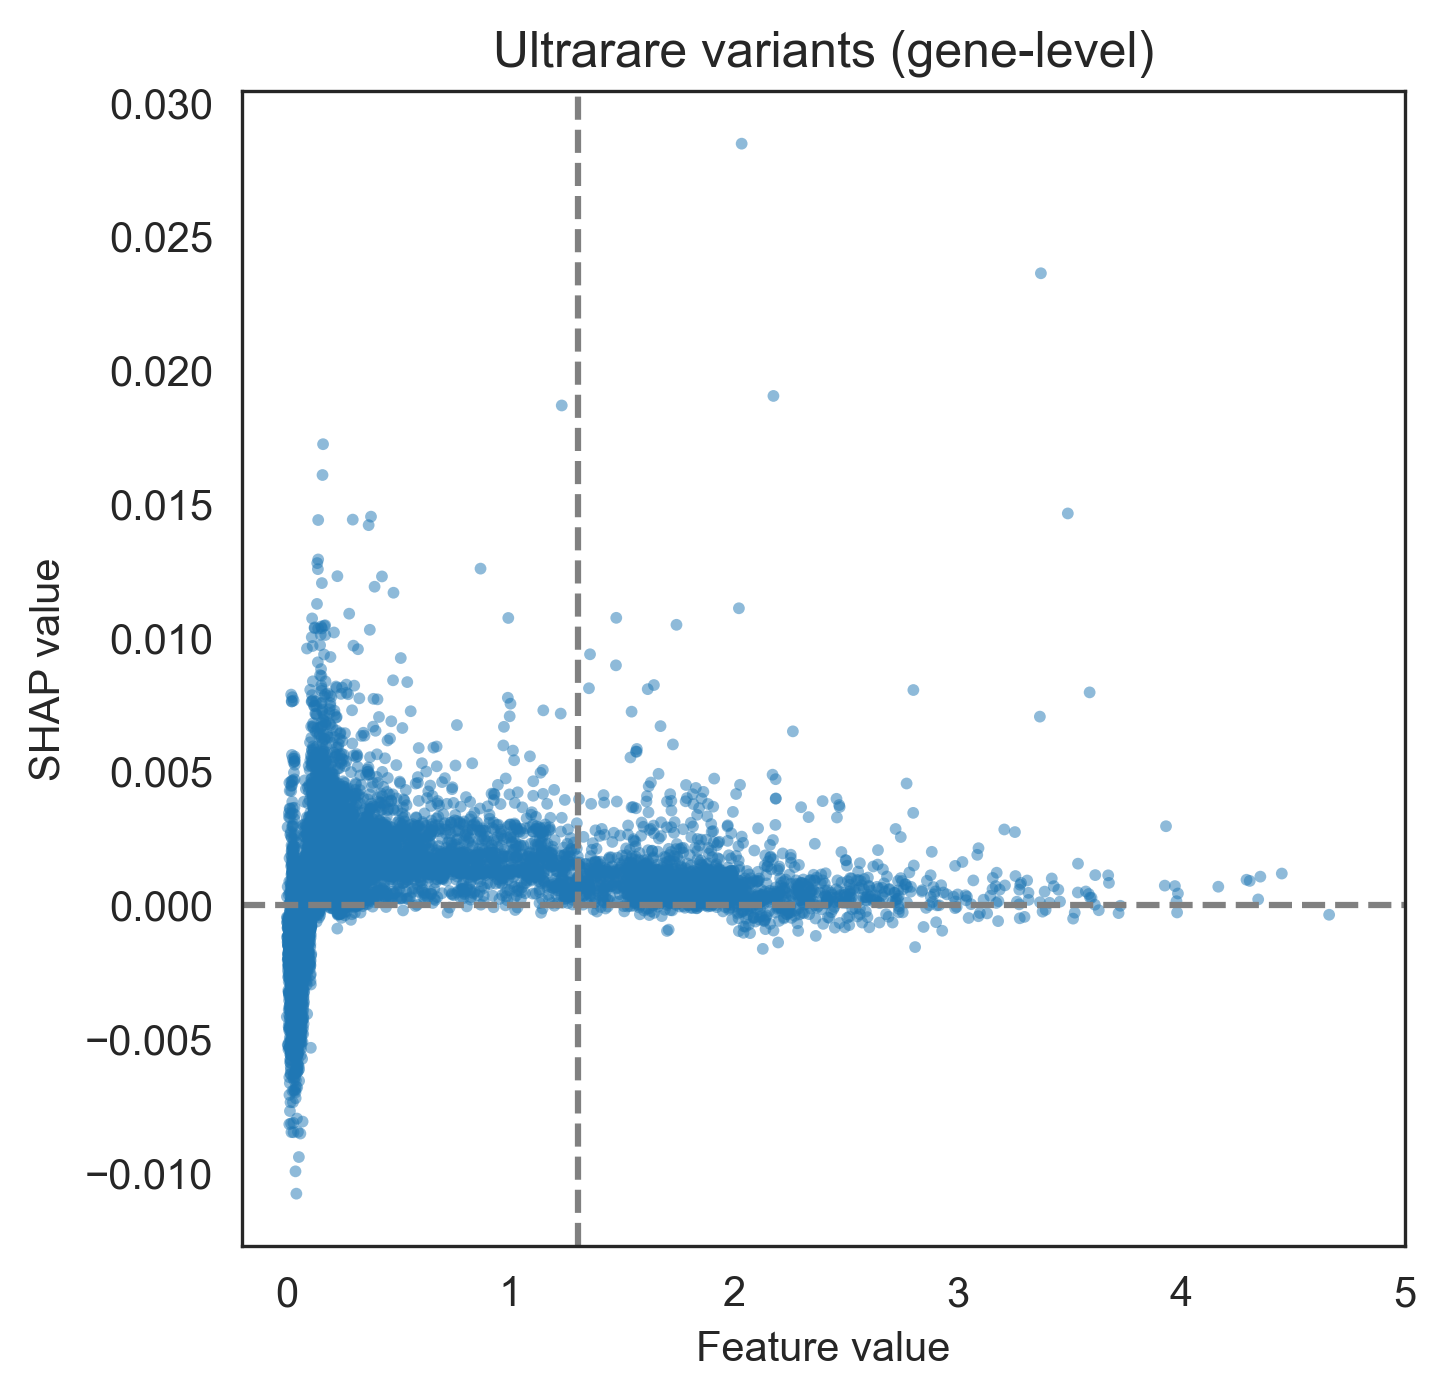

In [21]:
feature = ['Common variants','Rare variants',
           'Rare variants (gene-level)',
           'Ultrarare variants (gene-level)'][3]
temp = shap[['id',feature]].set_axis(['id','SHAP value'],axis=1)\
        .merge(shapdata[['id',feature]].set_axis(['id','Feature value'],axis=1), on='id')
temp = temp.loc[temp['Feature value'].notna()]

plt.figure(figsize=(5, 5), dpi=300)
sns.set_style('white')

sns.scatterplot(temp.sample(frac=0.1), x='Feature value', y='SHAP value', alpha=0.5,
                s=8, edgecolor='none')

plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=1.301, color='gray', linestyle='--')
plt.title(feature)
if feature == 'Common variants':
    plt.xlim([1,7.35])
elif feature == 'Rare variants':
    plt.xlim([-0.2,6.85])
elif feature == 'Rare variants (gene-level)':
    plt.xlim([-0.2,6])
elif feature == 'Ultrarare variants (gene-level)':
    plt.xlim([-0.2,5])
elif feature == 'FinnGen variants':
    plt.xlim([1,7.35])

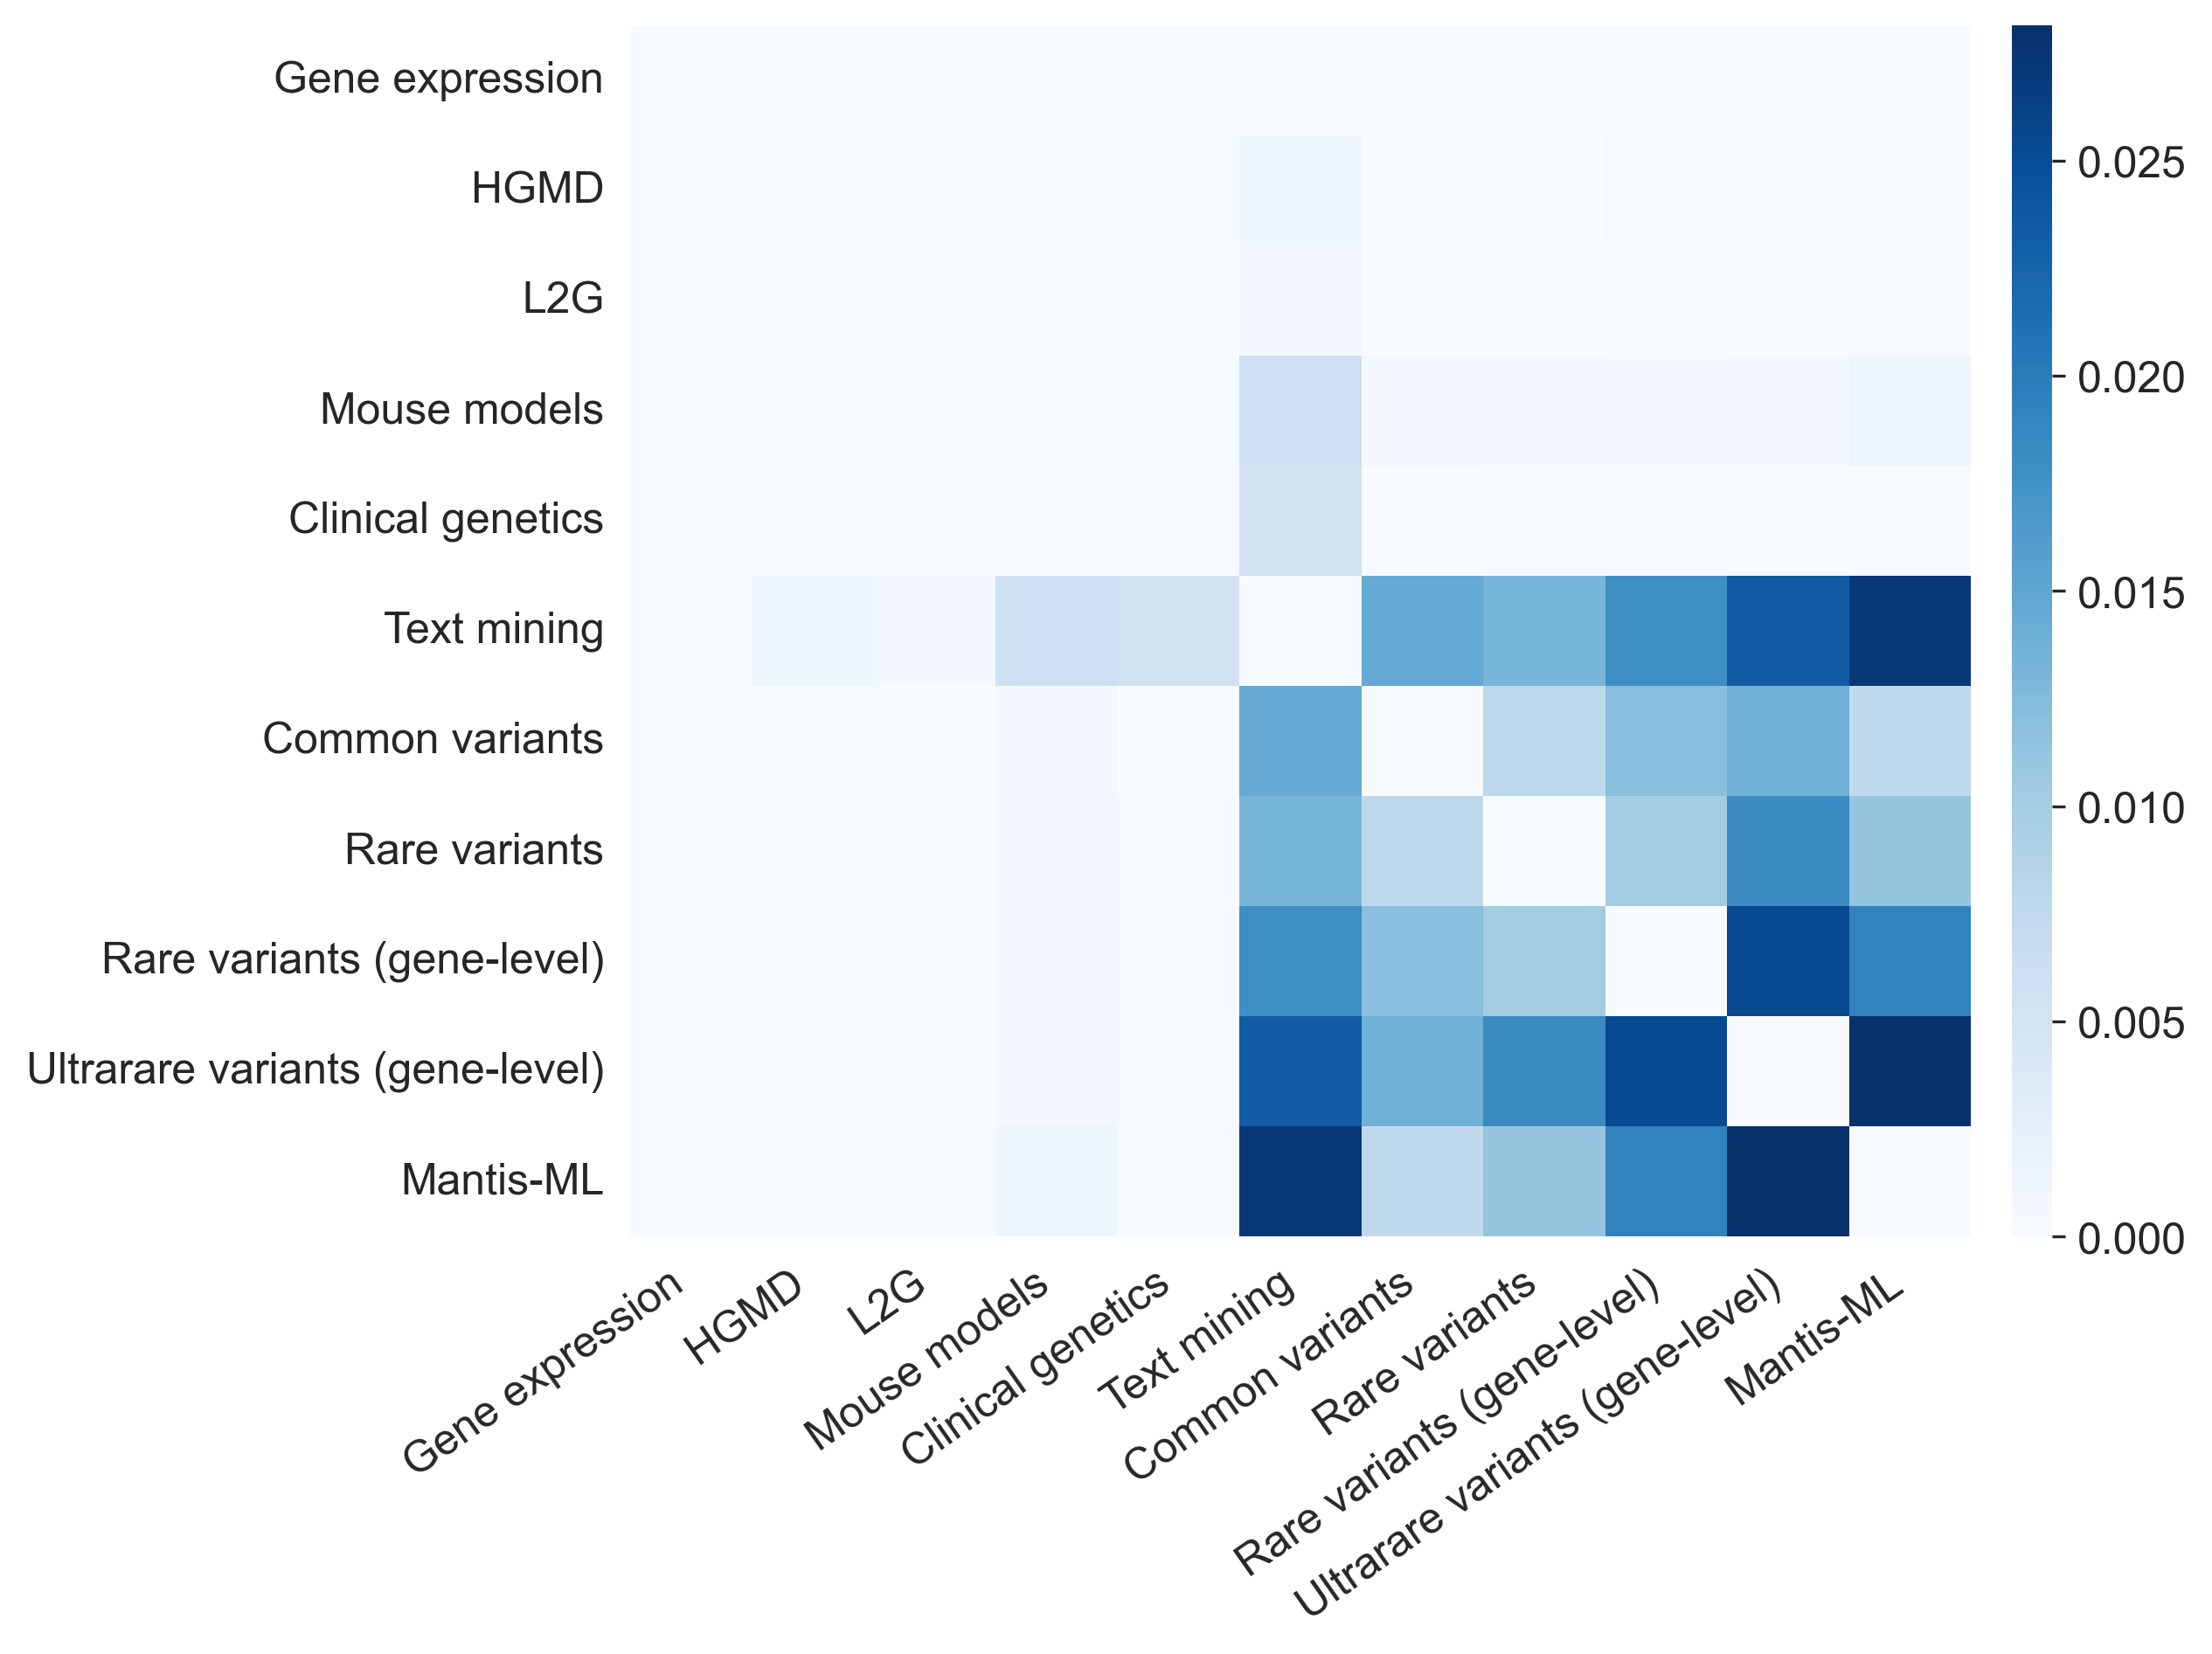

In [10]:
si = pd.read_pickle('./GPS/Main/SHAP/holdout_shap_ot_mantis_cc_interactions.pkl')
si = si.set_axis(['Clinical genetics','HGMD','L2G','Gene expression',
                      'Mouse models','Text mining','Mantis-ML','Common variants','Rare variants',
                      'Rare variants (gene-level)','Ultrarare variants (gene-level)'],axis=1)
si.index = ['Clinical genetics','HGMD','L2G','Gene expression',
                      'Mouse models','Text mining','Mantis-ML','Common variants','Rare variants',
                      'Rare variants (gene-level)','Ultrarare variants (gene-level)']
cols = ['Gene expression','HGMD','L2G','Mouse models','Clinical genetics','Text mining',
        'Common variants','Rare variants','Rare variants (gene-level)','Ultrarare variants (gene-level)',
        'Mantis-ML']
si = si[cols].reindex(cols)

for i in range(len(si)):
    si.iloc[i, i] = 0

plt.figure(figsize=(8, 6), dpi=300)
sns.set_style('white')

sns.heatmap(si, cmap='Blues', vmin=0, cbar_kws={'pad': 0.025, 'aspect':30})

a = plt.xticks(rotation=35, ha='right')

